# Preprocessing

In [228]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.tsa.api as smt
import seaborn as sns
from scipy import stats
from scipy.stats.stats import pearsonr
from IPython.core.display import display, HTML
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline
display(HTML("<style>.container { width:100% !important; }</style>"))

In [229]:
# Load data, convert RegimeType to dummy varibles, drop unneeded columns
df_all_raw = pd.read_excel('Happiness Dataset.xlsx', sheet_name='Main')
dummy = pd.get_dummies(df_all_raw['RegimeType'])
df_all_raw = df_all_raw.drop(['Country', 'CountryCode', 'HappinessRank', 
                              'RegimeType', 'PopulationInThousands'], axis=1)
df_all_raw = pd.concat([df_all_raw, dummy], axis=1)
df_all_raw.head()

,HappinessScore,GDPPerCapita,UnemploymentPercent,InfantMortalityRatePer1000,GiniIndex,DemocracyScore,ReligonImportance,FreedomOfPress,MedianAge,IndividualsUsingInternetPer100,Authoritarian,Flawed democracy,Full democracy,Hybrid regime
0,6.95,42443.47,4.2,3.4,31.7,8.68,0.40,14.60,47.1,116,0,0,1,0
1,5.96,30830.92,11.4,3.0,35.4,7.71,0.72,24.98,45.5,359,0,1,0,0
2,5.76,21617.58,8.1,2.5,25.4,7.50,0.47,22.31,44.5,143,0,1,0,0
3,5.23,18116.46,23.0,3.3,36.0,7.29,0.71,29.08,44.5,374,0,1,0,0
4,7.01,45103.33,6.2,3.3,30.5,8.29,0.55,15.33,44.0,118,0,0,1,0


In [230]:
# Drop one of the dummy variables to avoid dummy variable trap
df_all_raw = df_all_raw.drop(['Flawed democracy'], axis=1)

In [231]:
# Check for null values
df_all_raw.isnull().any()

HappinessScore                    False
GDPPerCapita                      False
UnemploymentPercent               False
InfantMortalityRatePer1000        False
GiniIndex                         False
DemocracyScore                    False
ReligonImportance                 False
FreedomOfPress                    False
MedianAge                         False
IndividualsUsingInternetPer100    False
Authoritarian                     False
Full democracy                    False
Hybrid regime                     False
dtype: bool

# Data Exploration

In [232]:
# View key stats
df_all_raw.describe()

,HappinessScore,GDPPerCapita,UnemploymentPercent,InfantMortalityRatePer1000,GiniIndex,DemocracyScore,ReligonImportance,FreedomOfPress,MedianAge,IndividualsUsingInternetPer100,Authoritarian,Full democracy,Hybrid regime
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,5.569697,15743.042424,8.513131,20.620202,37.816869,6.296263,0.688081,30.575960,32.324242,292.171717,0.171717,0.181818,0.242424
std,1.128674,19958.720904,5.712065,20.386996,8.080336,1.922144,0.259039,13.363267,9.180226,393.164582,0.379054,0.387657,0.430730
min,3.470000,315.780000,0.500000,2.300000,25.000000,1.930000,0.160000,7.820000,15.400000,11.000000,0.000000,0.000000,0.000000
25%,4.665000,2611.980000,5.250000,4.150000,32.350000,5.155000,0.425000,22.200000,24.500000,68.500000,0.000000,0.000000,0.000000
50%,5.570000,7028.940000,6.800000,12.700000,36.200000,6.410000,0.760000,29.780000,32.000000,134.000000,0.000000,0.000000,0.000000
75%,6.450000,19220.395000,10.500000,31.050000,42.950000,7.795000,0.925000,36.160000,41.150000,305.000000,0.000000,0.000000,0.000000
max,7.540000,101305.530000,27.300000,69.800000,63.000000,9.870000,1.000000,78.920000,47.100000,2358.000000,1.000000,1.000000,1.000000


<Figure size 432x288 with 0 Axes>

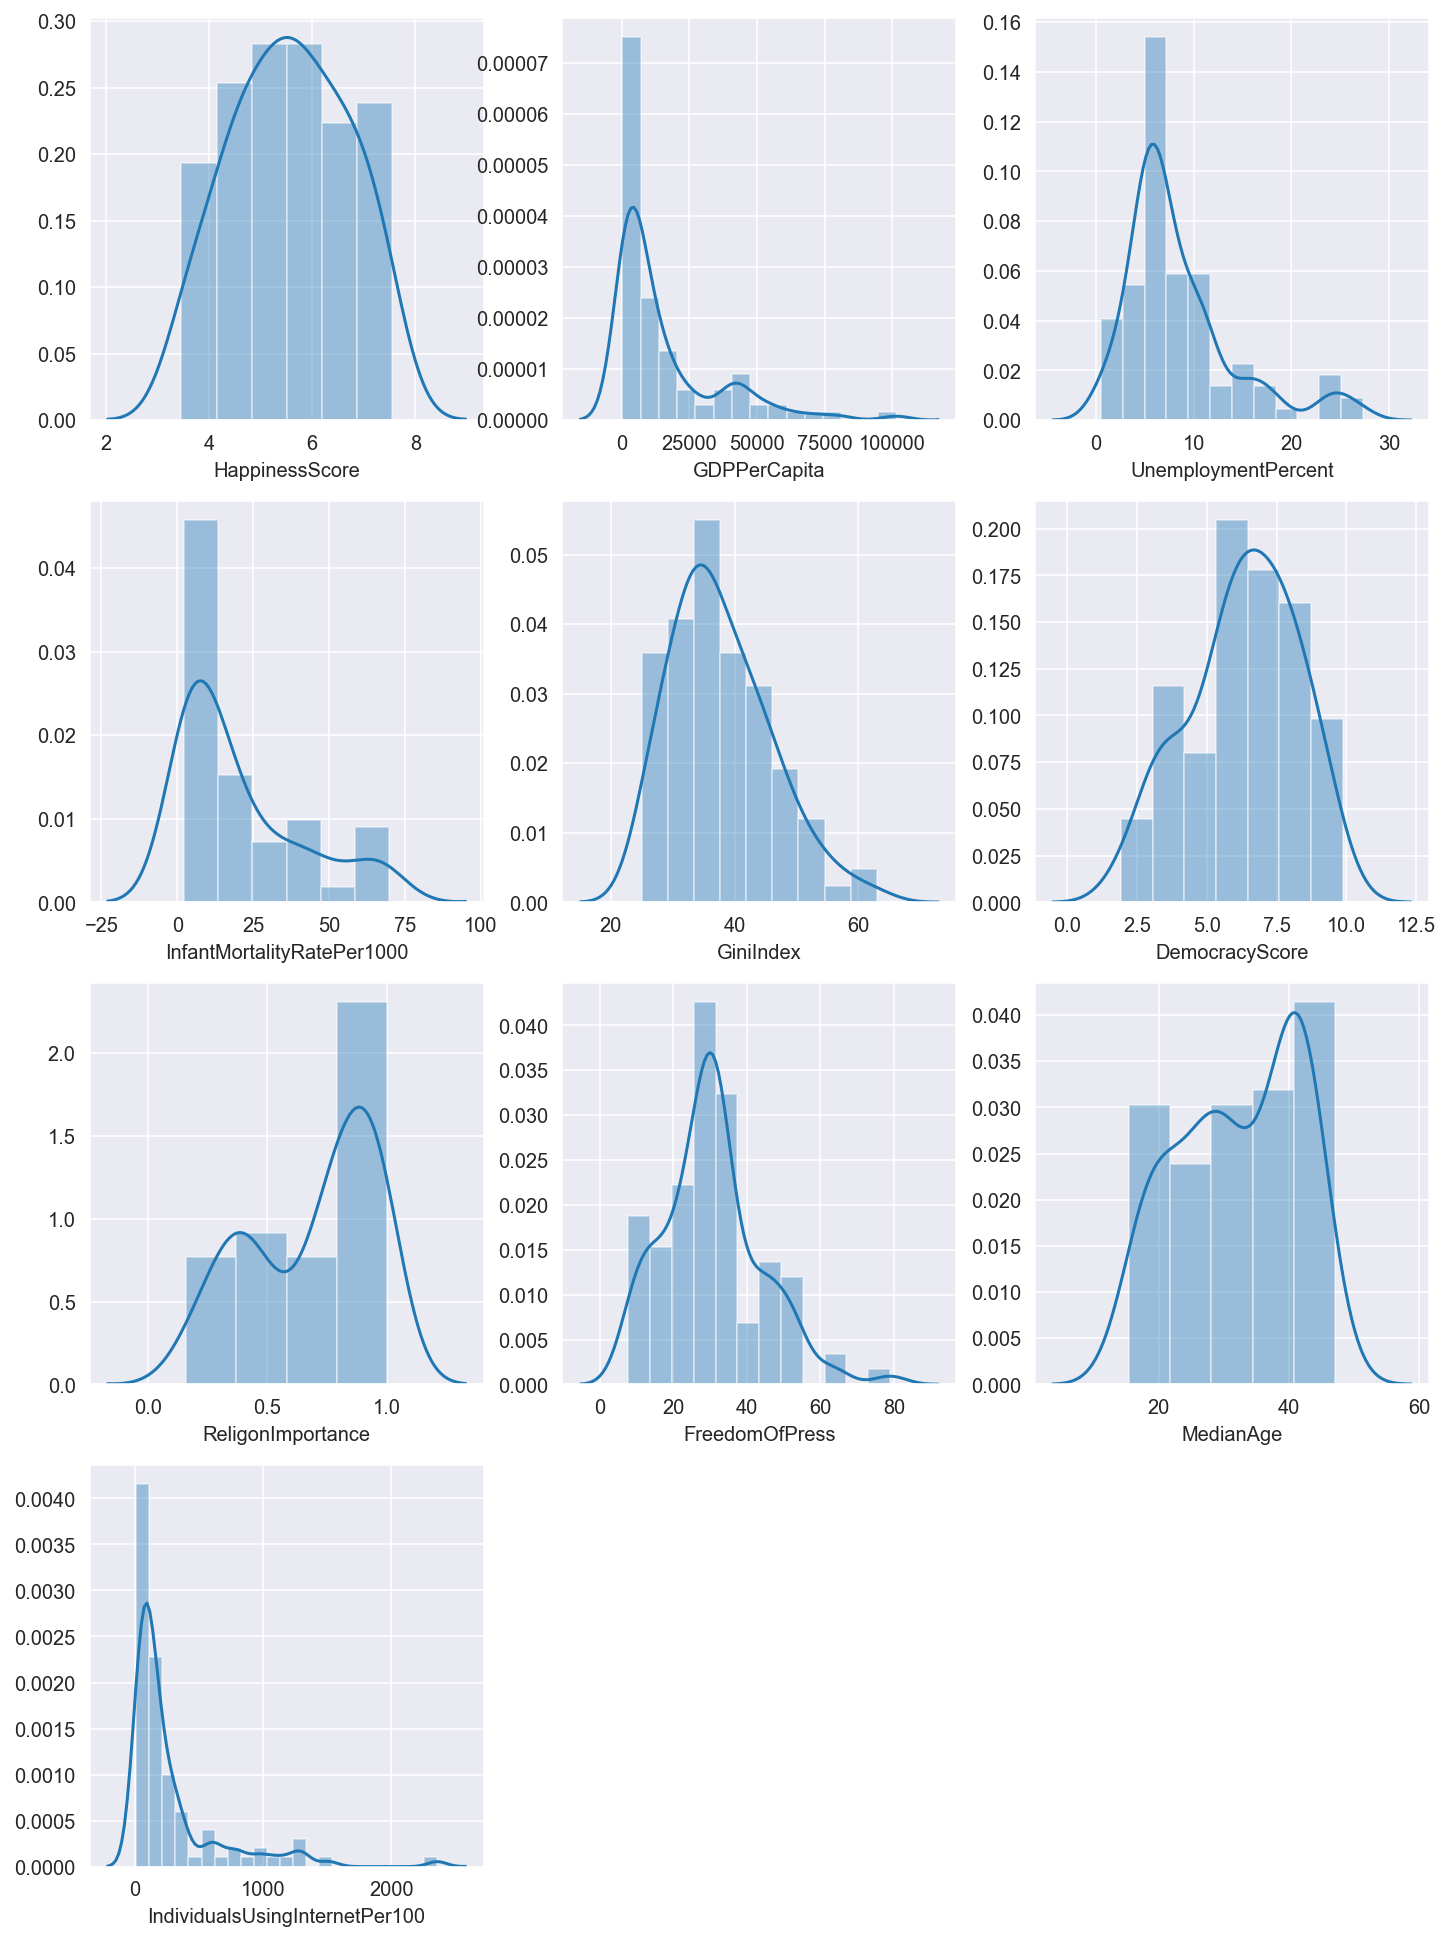

In [233]:
# View distribution of non-categorical data
df_non_cat = df_all_raw.drop(['Authoritarian', 'Full democracy', 'Hybrid regime'], axis=1)

def dist_plots(df_to_plot):
    """Create distribution plots for all (non-categorical) columns in dataframe."""
    fig = plt.figure()
    fig, axes = plt.subplots(figsize=(12,17))
    for i, col in enumerate(df_to_plot.columns, 1):
        plt.subplot(4, 3, i)
        sns.distplot(df_to_plot[col])
        
dist_plots(df_non_cat)

<Figure size 432x288 with 0 Axes>

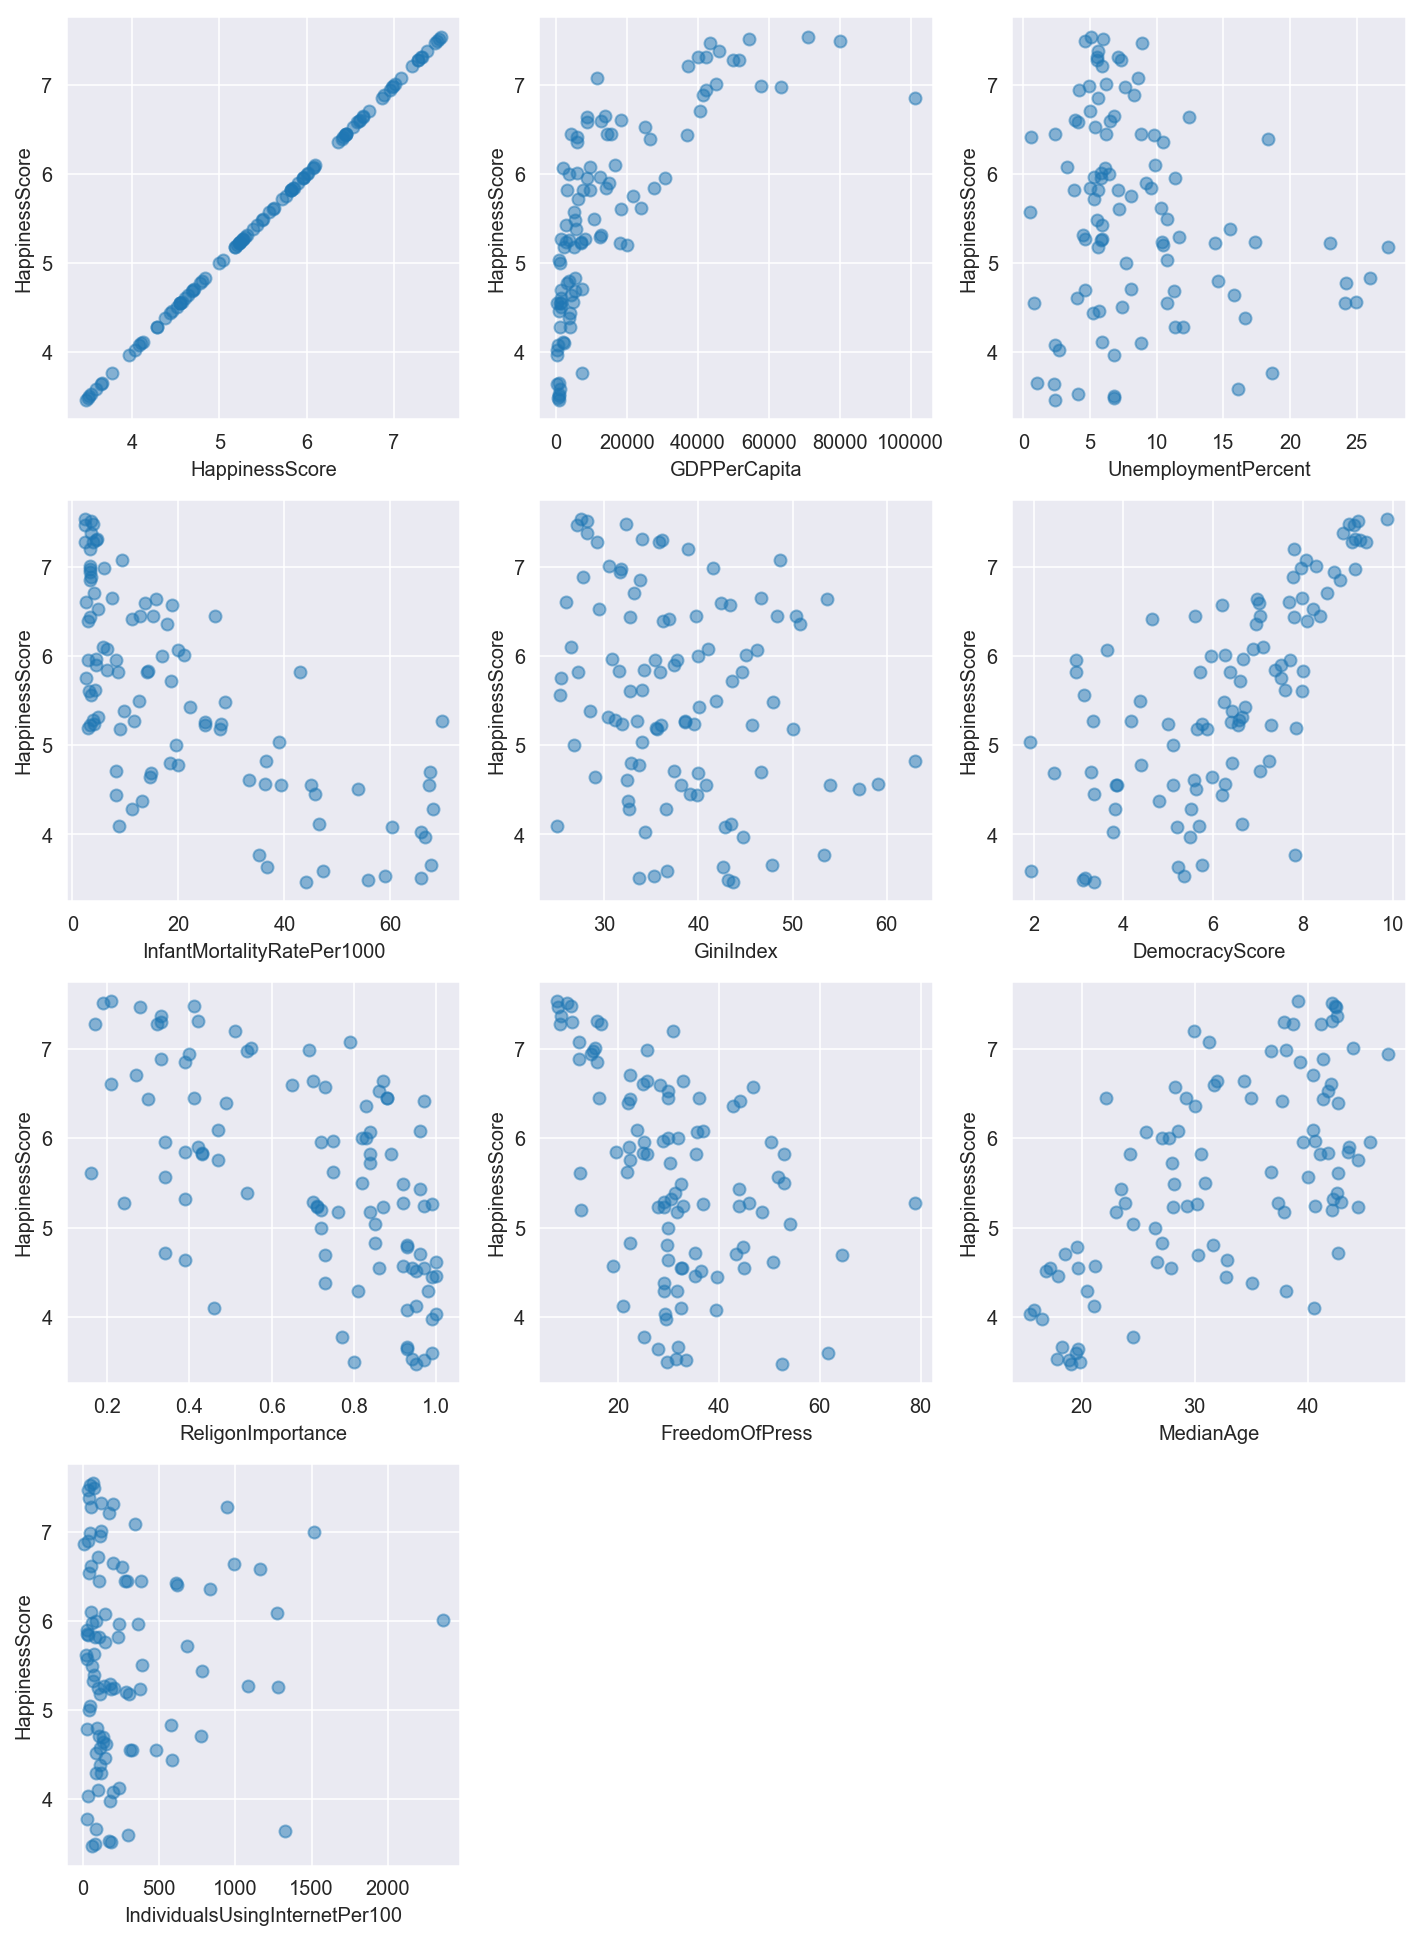

In [234]:
# Visualize relationship between explanatory variables and y through scatter plots

def scatter_plots(X, y):
    """
    Create scatter plots for all explanatory variables.
    
    Args: 
    X (df): Dataframe with all independent variables and the dependent variable.
    y (array): Dependent variable.
    """
    fig = plt.figure()
    fig, axes = plt.subplots(figsize=(12,17))
    for i, col in enumerate(X.columns, 1):
        plt.subplot(4, 3, i)
        plt.scatter(X[col], y, alpha=0.5)
        plt.xlabel(col)
        plt.ylabel("HappinessScore")
    
scatter_plots(df_non_cat, df_non_cat['HappinessScore'])

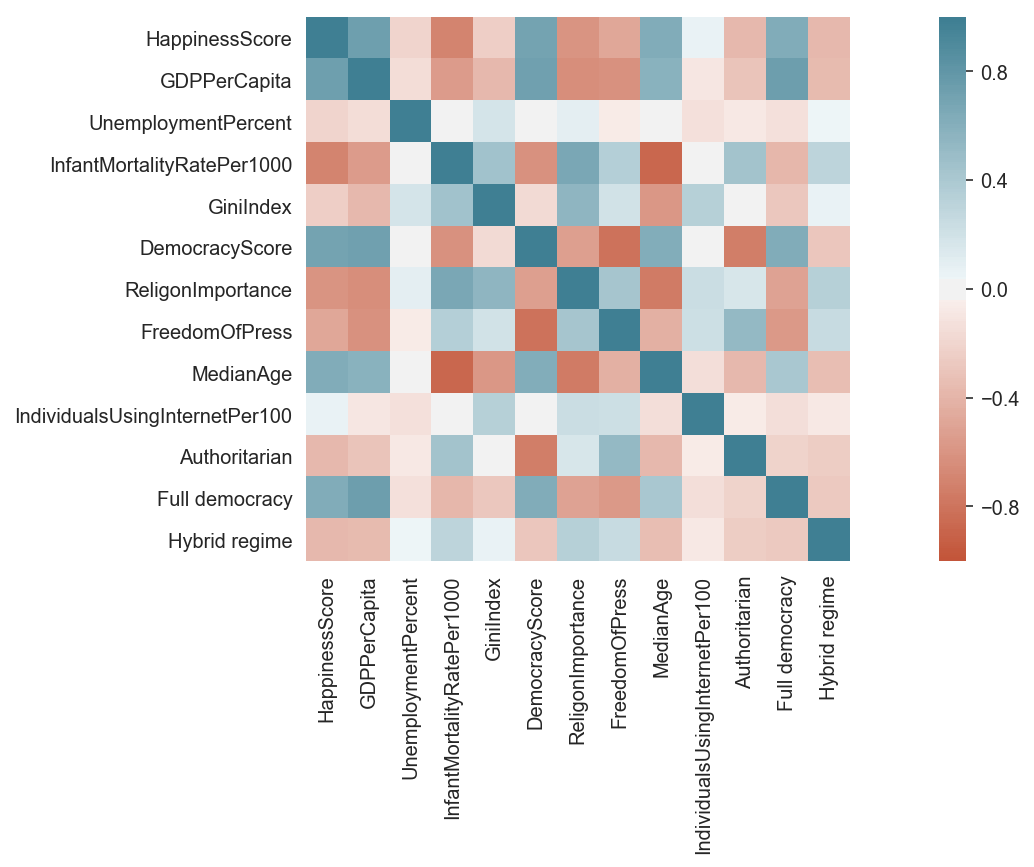

In [236]:
# View correlation matrix

def correlation_matrix(df_to_matrix):
    """Create correlation matrix containing all columns in dataframe"""
    corr = df_to_matrix.corr()
    plt.figure(figsize = (16,5))
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
    );
    
correlation_matrix(df_all_raw)

# Modeling: Linear Regression

### OLS - All Nations - All Features

In [297]:
# Create X and y. Verify dtypes. 
y = df_all_raw['HappinessScore']
X = df_all_raw.drop(['HappinessScore'], axis=1)
X.dtypes

GDPPerCapita                      float64
UnemploymentPercent               float64
InfantMortalityRatePer1000        float64
GiniIndex                         float64
DemocracyScore                    float64
ReligonImportance                 float64
FreedomOfPress                    float64
MedianAge                         float64
IndividualsUsingInternetPer100      int64
Authoritarian                       uint8
Full democracy                      uint8
Hybrid regime                       uint8
dtype: object

In [298]:
# OLS Regression

def ols_regression(X, y):
    """Fit regression model and summarize results"""
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    return model.summary()

ols_regression(X, y)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         HappinessScore   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     22.11
Date:                Sun, 25 Aug 2019   Prob (F-statistic):           2.28e-21
Time:                        18:37:16   Log-Likelihood:                -82.293
No. Observations:                  99   AIC:                             190.6
Df Residuals:                      86   BIC:                             224.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              5.2034      1.560      3.336      0.001       2.103       8.304
GDPPerCapita                    1.421e-05   6.02e-06      2.360      0.021    2.24e-06    2.62e-05
UnemploymentPercent               -0.0329      0.012     -2.798      0.006      -0.056      -0.010
InfantMortalityRatePer1000        -0.0273      0.007     -3.934      0.000      -0.041      -0.013
GiniIndex                          0.0235      0.012      2.038      0.045       0.001       0.046
DemocracyScore                     0.0461      0.159      0.289      0.773      -0.271       0.363
ReligonImportance                 -0.2875      0.431     -0.667      0.507      -1.145       0.570
FreedomOfPress                     0.0012      0.009      0.130      0.897      -0.017       0.020
MedianAge                         -0.0049      0.018     -0.278      0.782      -0.040       0.030
IndividualsUsingInternetPer100     0.0001      0.000      0.813      0.419      -0.000       0.001
Authoritarian                     -0.0411      0.562     -0.073      0.942      -1.159       1.077
Full democracy                     0.6483      0.271      2.390      0.019       0.109       1.188
Hybrid regime                     -0.1224      0.276     -0.443      0.659      -0.672       0.427
==============================================================================
Omnibus:                        2.763   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.251   Jarque-Bera (JB):                2.118
Skew:                          -0.292   Prob(JB):                        0.347
Kurtosis:                       3.414   Cond. No.                     6.94e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.94e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### OLS - All Nations - Best Features

In [329]:
# Remove features with p-values greater than 0.05
X_best = X.drop(['DemocracyScore', 'ReligonImportance', 'FreedomOfPress', 'MedianAge',
                 'IndividualsUsingInternetPer100', 'Authoritarian', 'Hybrid regime'], axis=1)

# Remove Gini Index due to high VIF (see validating assumptions below)
X_best = X_best.drop(['GiniIndex'], axis=1)


In [330]:
# OLS Regression with best features
ols_regression(X_best, y)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         HappinessScore   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     58.96
Date:                Sun, 25 Aug 2019   Prob (F-statistic):           8.22e-25
Time:                        18:39:33   Log-Likelihood:                -89.816
No. Observations:                  99   AIC:                             189.6
Df Residuals:                      94   BIC:                             202.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          5.9760      0.178     33.599      0.000       5.623       6.329
GDPPerCapita                1.608e-05   5.25e-06      3.061      0.003    5.65e-06    2.65e-05
UnemploymentPercent           -0.0288      0.011     -2.594      0.011      -0.051      -0.007
InfantMortalityRatePer1000    -0.0259      0.004     -7.033      0.000      -0.033      -0.019
Full democracy                 0.6640      0.242      2.743      0.007       0.183       1.145
==============================================================================
Omnibus:                        0.252   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.882   Jarque-Bera (JB):                0.349
Skew:                          -0.113   Prob(JB):                        0.840
Kurtosis:                       2.818   Cond. No.                     9.97e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.97e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### OLS - All Nations - Best Features Z-Scores

In [331]:
# Create dataframe with z-scores to standardize coefficients in OLS analysis
df_to_z = X_best.copy()

def x_scores_to_df(df_to_z):
    """Create dataframe with z-scores of independent variables."""
    cols = list(df_to_z.columns)
    df_to_z[cols]
    # Append new columns with each independent variable's z-scores
    for col in cols:
        col_zscore = col + '_zscore'
        df_to_z[col_zscore] = (df_to_z[col] - df_to_z[col].mean())/df_to_z[col].std(ddof=0)
    # Remove original, non-z-score columns
    for col in cols:
        if "_zscore" not in col:
            df_to_z = df_to_z.drop([col], axis=1)
    return df_to_z

df_z = x_scores_to_df(df_to_z)

In [332]:
# OLS Regression with z-scores of best features
ols_regression(df_z, y)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         HappinessScore   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     58.96
Date:                Sun, 25 Aug 2019   Prob (F-statistic):           8.22e-25
Time:                        18:39:44   Log-Likelihood:                -89.816
No. Observations:                  99   AIC:                             189.6
Df Residuals:                      94   BIC:                             202.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 5.5697      0.062     90.080      0.000       5.447       5.692
GDPPerCapita_zscore                   0.3194      0.104      3.061      0.003       0.112       0.527
UnemploymentPercent_zscore           -0.1638      0.063     -2.594      0.011      -0.289      -0.038
InfantMortalityRatePer1000_zscore    -0.5262      0.075     -7.033      0.000      -0.675      -0.378
Full democracy_zscore                 0.2561      0.093      2.743      0.007       0.071       0.441
==============================================================================
Omnibus:                        0.252   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.882   Jarque-Bera (JB):                0.349
Skew:                          -0.113   Prob(JB):                        0.840
Kurtosis:                       2.818   Cond. No.                         3.13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### OLS - Developed (High HDI) Nations - All Features

In [333]:
# Filter for developed nations, defined as nations with GDP Per Capita over 20,000 USD
df_hdi = df_all_raw.drop(['ReligonImportance', 'FreedomOfPress', 'MedianAge',
                         'IndividualsUsingInternetPer100', 'Authoritarian', 'Hybrid regime'], axis=1)
df_hdi = df_hdi[df_hdi['GDPPerCapita']>20000]

df_hdi.head()

,HappinessScore,GDPPerCapita,UnemploymentPercent,InfantMortalityRatePer1000,GiniIndex,DemocracyScore,Full democracy
0,6.95,42443.47,4.2,3.4,31.7,8.68,1
1,5.96,30830.92,11.4,3.0,35.4,7.71,0
2,5.76,21617.58,8.1,2.5,25.4,7.50,0
4,7.01,45103.33,6.2,3.3,30.5,8.29,1
10,6.40,26622.30,18.3,2.9,36.2,8.08,1


In [334]:
# Create X and y. Verify dtypes. 
y_hdi = df_hdi['HappinessScore']
X_hdi = df_hdi.drop(['HappinessScore'], axis=1)
X_hdi.dtypes

GDPPerCapita                  float64
UnemploymentPercent           float64
InfantMortalityRatePer1000    float64
GiniIndex                     float64
DemocracyScore                float64
Full democracy                  uint8
dtype: object

In [335]:
# OLS regression of all features of HDI countries
ols_regression(X_hdi, y_hdi)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         HappinessScore   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     8.107
Date:                Sun, 25 Aug 2019   Prob (F-statistic):           0.000303
Time:                        18:40:01   Log-Likelihood:                -4.6691
No. Observations:                  24   AIC:                             23.34
Df Residuals:                      17   BIC:                             31.58
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          1.6720      1.913      0.874      0.394      -2.365       5.709
GDPPerCapita                6.336e-07   5.28e-06      0.120      0.906   -1.05e-05    1.18e-05
UnemploymentPercent           -0.0513      0.030     -1.736      0.101      -0.114       0.011
InfantMortalityRatePer1000    -0.0761      0.036     -2.088      0.052      -0.153       0.001
GiniIndex                      0.0257      0.020      1.300      0.211      -0.016       0.067
DemocracyScore                 0.5894      0.219      2.686      0.016       0.126       1.052
Full democracy                -0.0361      0.275     -0.131      0.897      -0.616       0.544
==============================================================================
Omnibus:                        0.825   Durbin-Watson:                   1.367
Prob(Omnibus):                  0.662   Jarque-Bera (JB):                0.731
Skew:                           0.086   Prob(JB):                        0.694
Kurtosis:                       2.162   Cond. No.                     1.34e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### OLS - Developed (High HDI) Nations - Best Features

In [336]:
# Remove previously insignificant features to see if we can get p-vales below 0.05
X_hdi_best = X_hdi.drop(['GDPPerCapita', 'GiniIndex', 'Full democracy'], axis=1)

In [337]:
# OLS regression of best features of HDI countries 
ols_regression(X_hdi_best, y_hdi)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         HappinessScore   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     16.42
Date:                Sun, 25 Aug 2019   Prob (F-statistic):           1.28e-05
Time:                        18:40:03   Log-Likelihood:                -5.9744
No. Observations:                  24   AIC:                             19.95
Df Residuals:                      20   BIC:                             24.66
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          2.8046      1.181      2.375      0.028       0.342       5.268
UnemploymentPercent           -0.0505      0.027     -1.875      0.075      -0.107       0.006
InfantMortalityRatePer1000    -0.0689      0.033     -2.070      0.052      -0.138       0.001
DemocracyScore                 0.5502      0.120      4.604      0.000       0.301       0.800
==============================================================================
Omnibus:                        0.178   Durbin-Watson:                   1.525
Prob(Omnibus):                  0.915   Jarque-Bera (JB):                0.386
Skew:                           0.082   Prob(JB):                        0.824
Kurtosis:                       2.401   Cond. No.                         205.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Validating Linear Regression Assumptions

In [338]:
def ols_model(X, y):
    """Fit regression model and summarize results"""
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    return model

model_best = ols_model(X_best, y)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


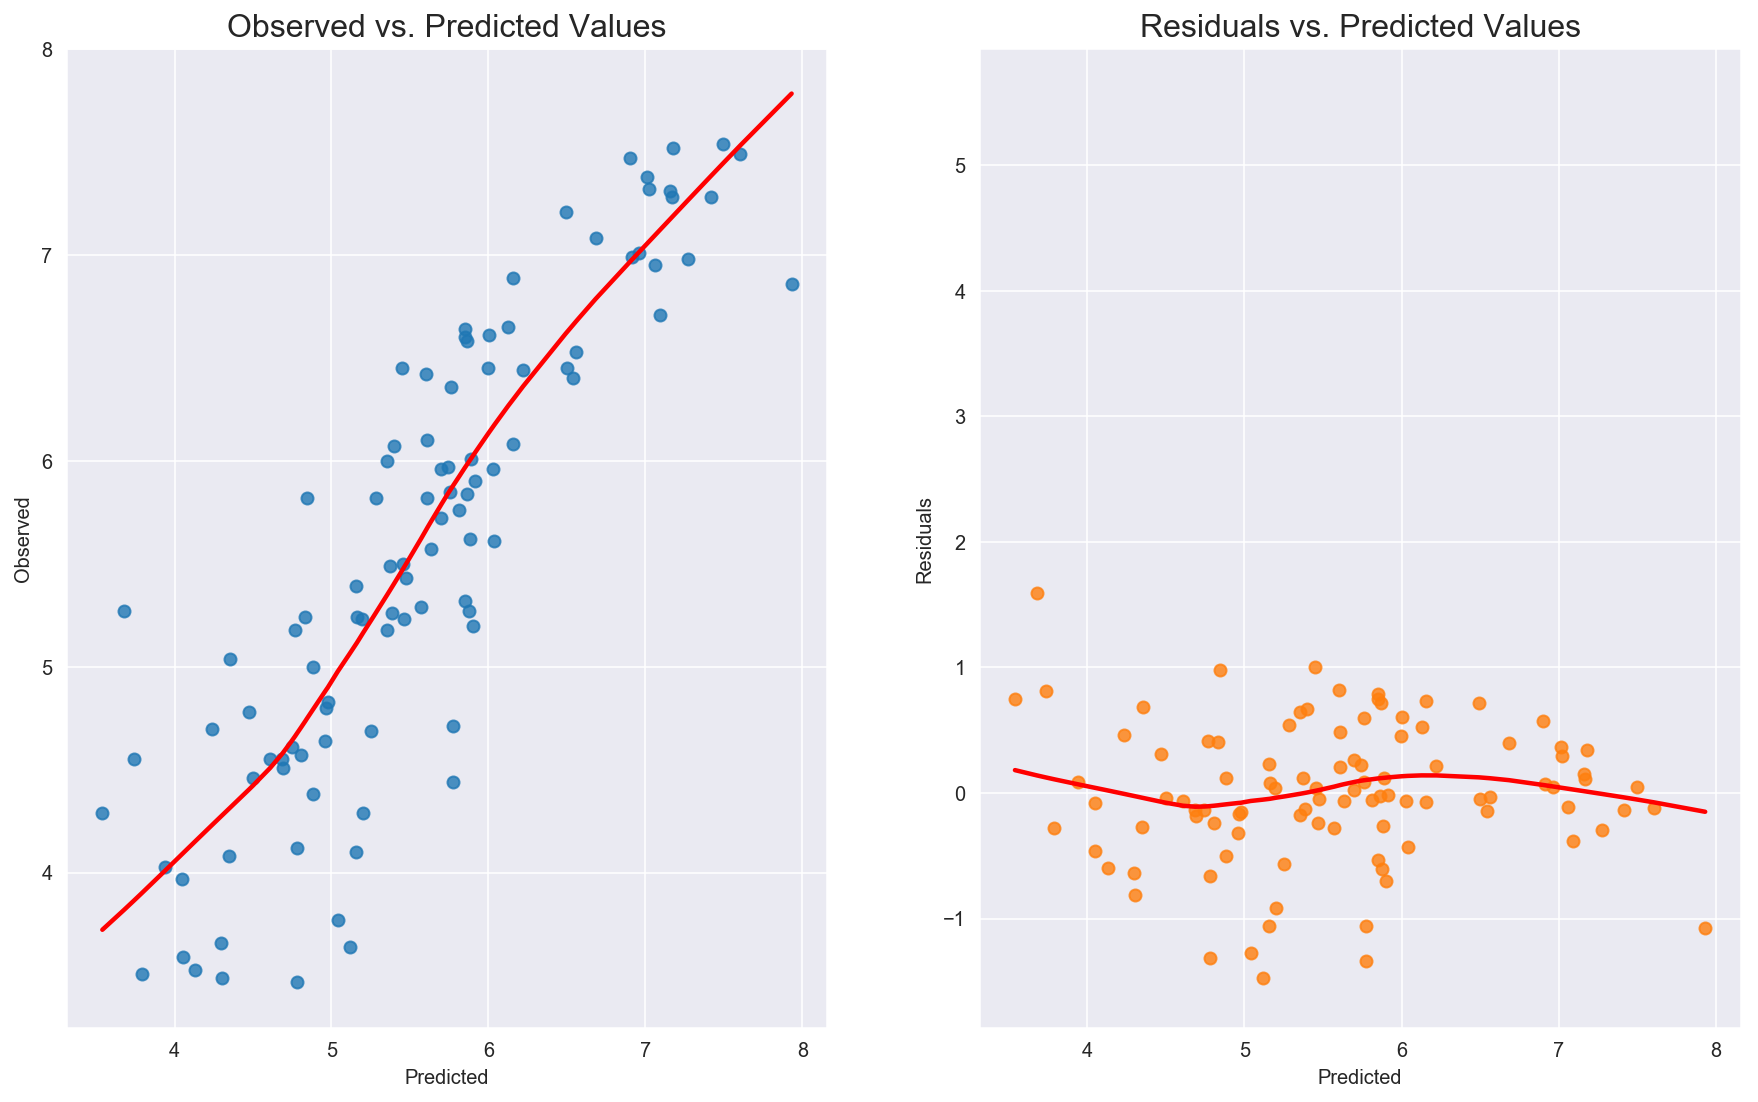

In [339]:
# Assumption 1: Linearity of the model
%config InlineBackend.figure_format ='retina'
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def linearity_test(model, y):
    '''
    Plots observed vs. predicted values and residuals vs. predicted values 
    in order to visually inspect the assumption of linearity.
    
    Args:
    model - fitted OLS model from statsmodels
    y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2)
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')
    
linearity_test(best_model, y)    

In [341]:
# Assumption 2: Mean of residuals is zero
model_best.resid.mean()

3.3423903375657544e-12

In [346]:
# Assumption 3: No Multicollinearity (VIF under 5)
vif = [variance_inflation_factor(X_best.values, i) for i in range(X_best.shape[1])]
pd.DataFrame({'vif': vif}, index=X_best.columns).T

,GDPPerCapita,UnemploymentPercent,InfantMortalityRatePer1000,Full democracy
vif,3.215728,1.933903,1.554369,2.765275


#### Gini Index has high VIF, therefore let's remove it from the final model


 Breusch-Pagan test ----
                                  value
Lagrange multiplier statistic  5.914736
p-value                        0.205607
f-value                        1.493215
f p-value                      0.210498

 Goldfeld-Quandt test ----
                value
F statistic  1.531033
p-value      0.079325

 Residuals plots ----


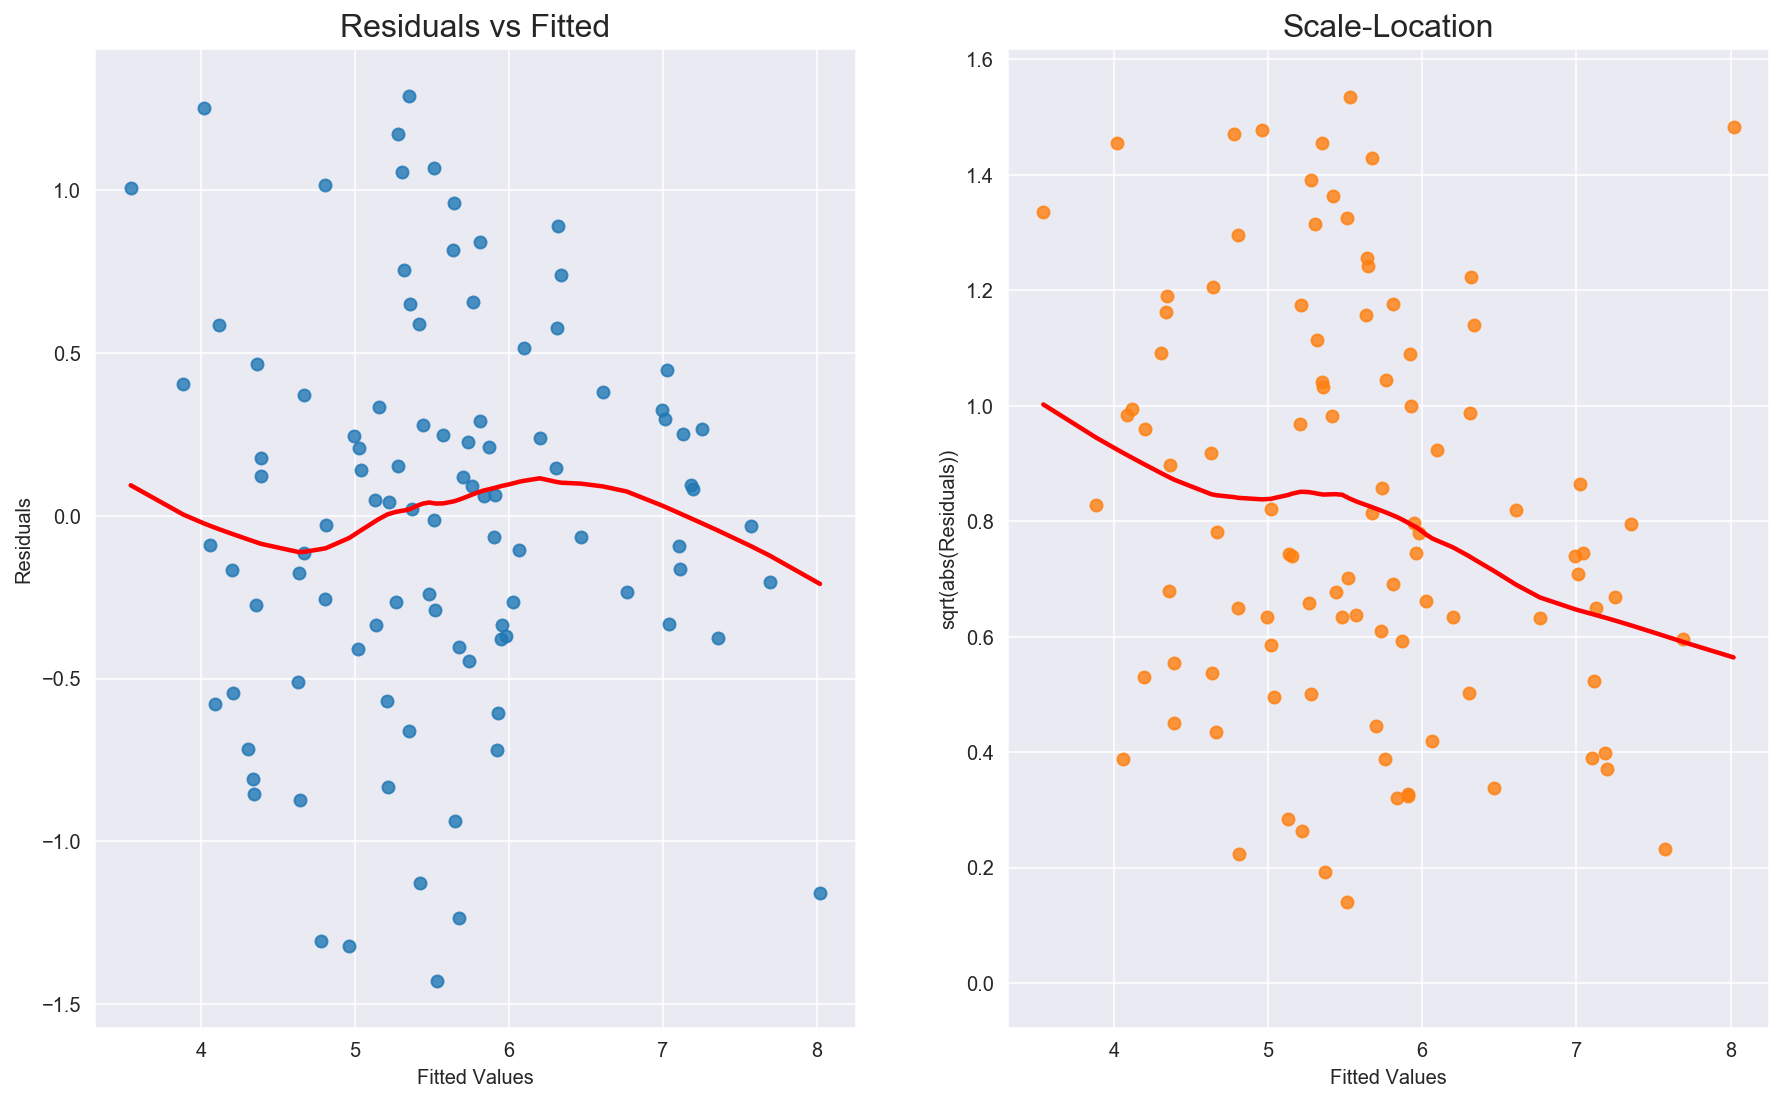

In [343]:
# Assumption 4: Homoscedasticity of residuals
%config InlineBackend.figure_format ='retina'
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def homoscedasticity_test(model):
    '''
    Plots residuals and standardized residuals vs. fitted values and runs 
    Breusch-Pagan and Goldfeld-Quandt tests.
    
    Arg:
    model - fitted OLS model from statsmodels
    '''
    fitted_vals = model.predict()
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2)

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])

    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    print('\n Residuals plots ----')

homoscedasticity_test(model_best)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


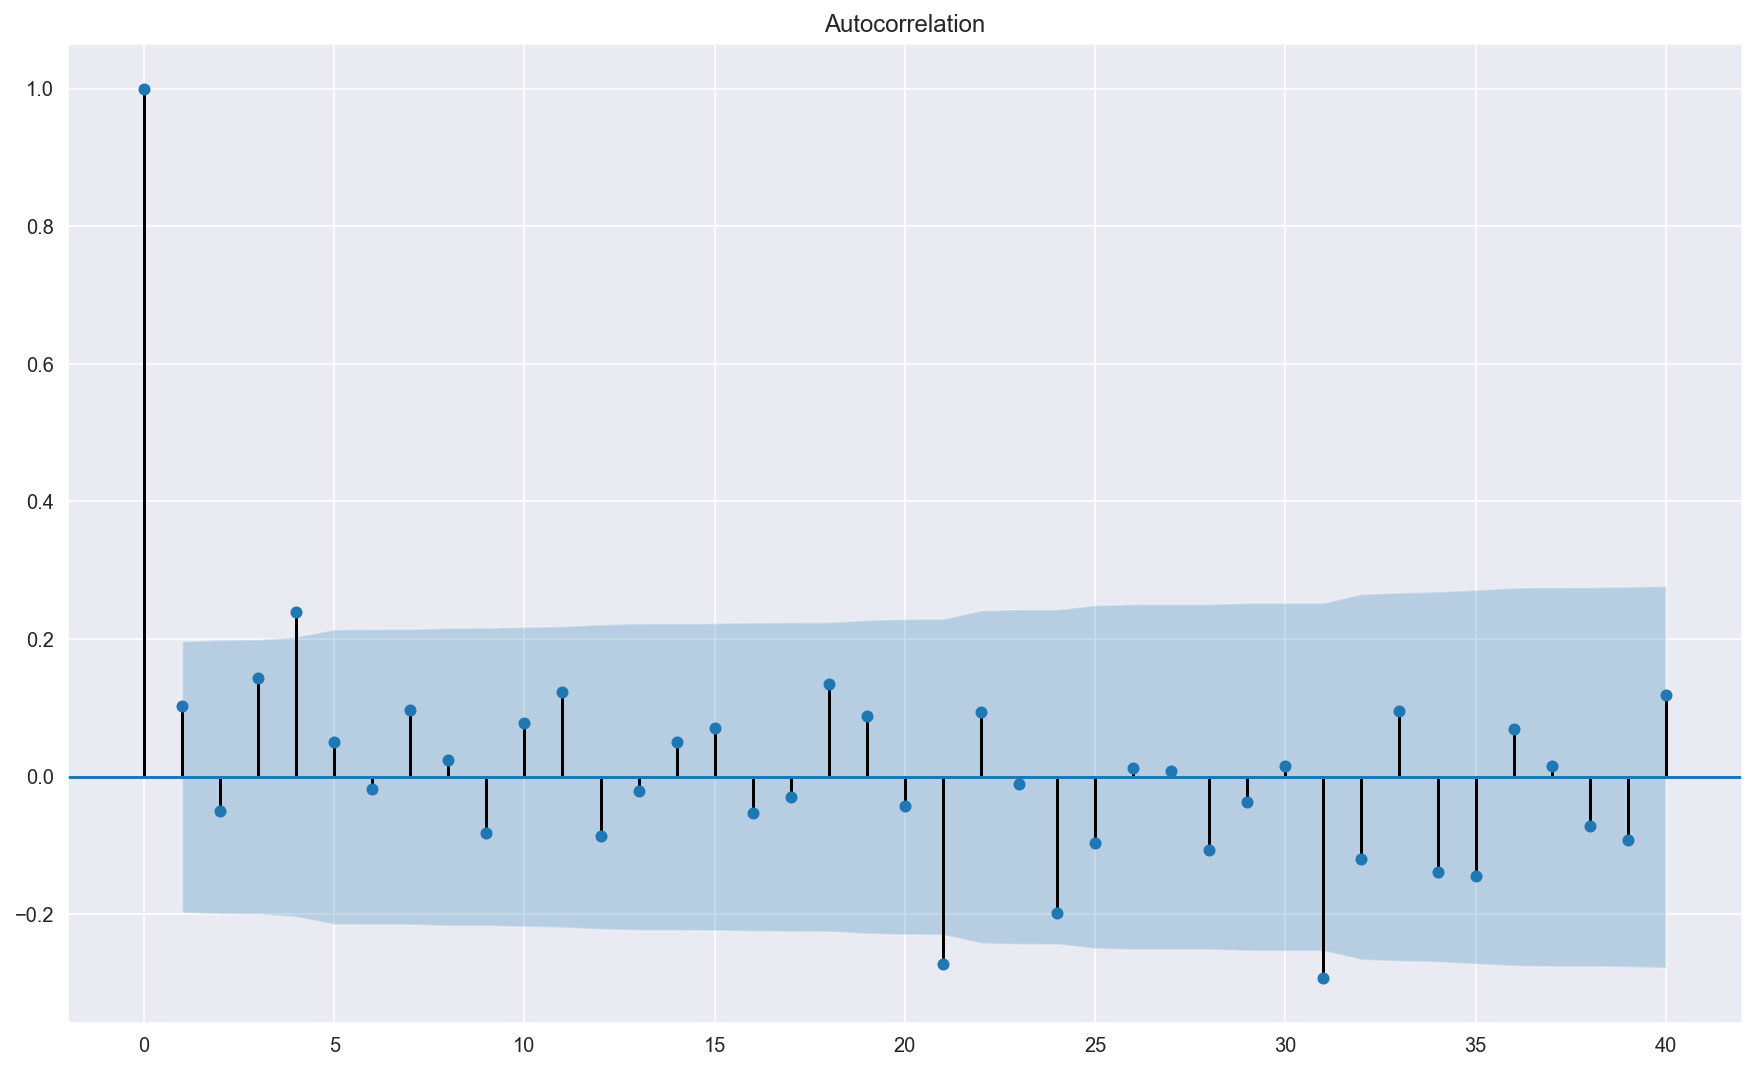

In [344]:
# Assumption 5: No auto-correlation

def acf_plot(model):
    """
    Plots the ACF to determine auto-correlation. 
    Also check Durbin-Watson score from model summary. If between 1.5 to 2.5
    you can assume no autocorrelation is detected.
    
    Arg:
    model - fitted OLS model from statsmodels
    """
    acf = smt.graphics.plot_acf(model_best.resid, lags=40 , alpha=0.05)
    acf.show()

acf_plot(model_best)

In [265]:
# Assumption 6: X variables and residuals are uncorrelated

def pearson_corr(X):
    """Prints Pearson correlation coefficient between each feature and residuals"""
    for column in X_best.columns:
        corr_test = pearsonr(X_best[column], model_best.resid)
        print('Variable: ' + str(column) + '--- correlation: ' + str(corr_test[0]) + ', p-value: ' + str(corr_test[1]))

pearson_corr(X_best)

Variable: GDPPerCapita--- correlation: 7.15687111188136e-16, p-value: 1.0
Variable: UnemploymentPercent--- correlation: 4.139301074906469e-15, p-value: 1.0
Variable: InfantMortalityRatePer1000--- correlation: 1.0052403089035227e-15, p-value: 1.0
Variable: GiniIndex--- correlation: -1.727826929645638e-15, p-value: 1.0
Variable: Full democracy--- correlation: 8.758805915299833e-16, p-value: 1.0


Jarque-Bera test ---- statistic:  0.34926348376035043 p-value:  0.8397662145614175
Shapiro-Wilk test ---- statistic: 0.988338828086853 p-value:  0.5408828854560852
Kolmogorov-Smirnov test ---- statistic: 0.13910233613894193 p-value: 0.03919564800727837
Anderson-Darling test ---- statistic: 0.26463499051317285 5% critical value: 0.758
If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 


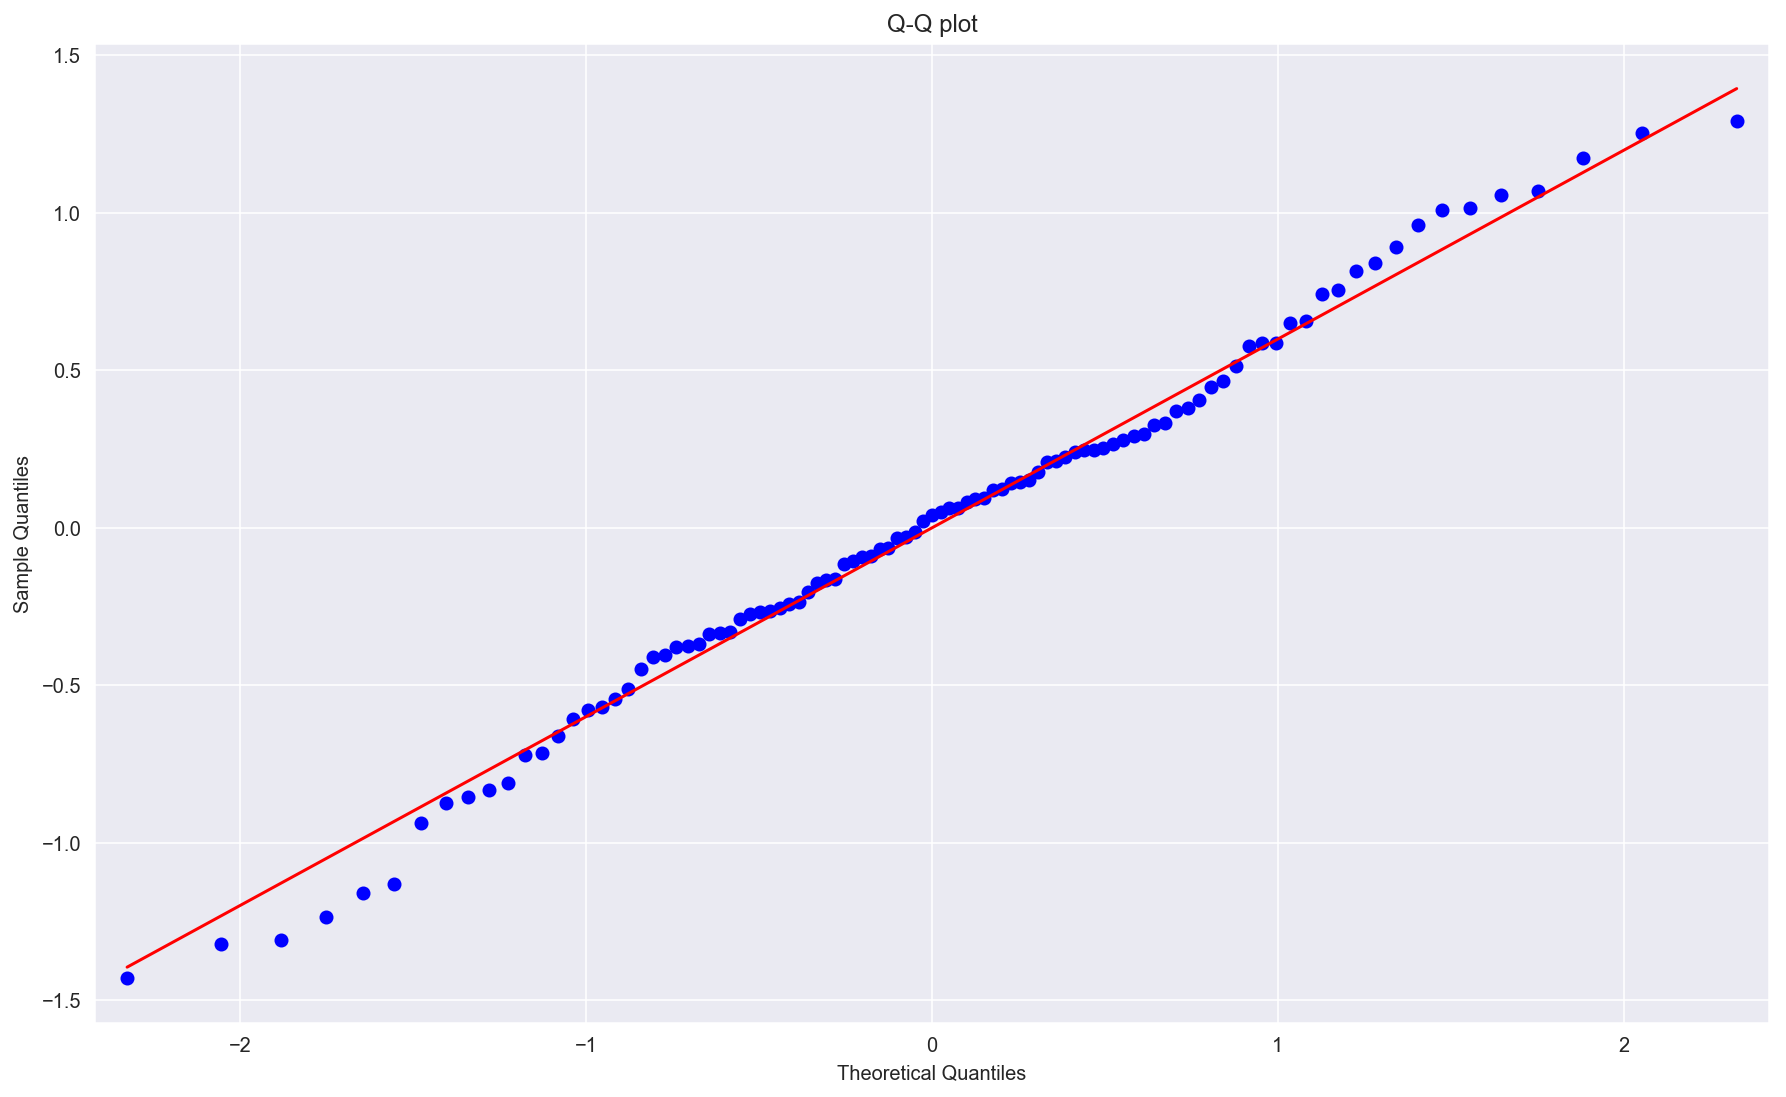

In [345]:
# Assumption 7: Normality of residuals

def normality_of_residuals_test(model):
    '''
    Drawing the normal QQ-plot of the residuals and running 4 statistical tests to 
    investigate the normality of residuals.
    
    Arg:
    model - fitted OLS model from statsmodels
    '''
    sm.ProbPlot(model.resid).qqplot(line='s');
    plt.title('Q-Q plot');

    jb = stats.jarque_bera(model.resid)
    sw = stats.shapiro(model.resid)
    ad = stats.anderson(model.resid, dist='norm')
    ks = stats.kstest(model.resid, 'norm')
    
    print('Jarque-Bera test ---- statistic: ', jb[0], 'p-value: ', jb[1])
    print('Shapiro-Wilk test ---- statistic:', sw[0], 'p-value: ', sw[1])
    print('Kolmogorov-Smirnov test ---- statistic:', ks.statistic, 'p-value:', ks.pvalue)
    print('Anderson-Darling test ---- statistic:', ad.statistic, '5% critical value:', ad.critical_values[2])
    print('If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. ')
    
normality_of_residuals_test(model_best)